# Домашнее задание 2 (60 pts)


## Настройка окружения


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from joblib.parallel import Parallel, delayed
from tqdm import tqdm
from functools import partial
from scipy.linalg import lu
from scipy.optimize import minimize
import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use("dark_background")
mpl.rcParams["axes.grid"] = True

measures = {
    "time": "s",
}

## Задача 1 (25 pts)

## PLU разложение

- (5 pts) Докажите, что LU разложение существует iff матрица является строго регулярной.

$\Rightarrow$

$
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix} =
\begin{bmatrix}
L_{11} & 0 \\
L_{21} & L_{22}
\end{bmatrix}
\begin{bmatrix}
U_{11} & U_{12} \\
0 & U_{22}
\end{bmatrix}
$
$\Rightarrow A_{11} = L_{11} U_{11} \Rightarrow |A_{11}| = |L_{11}| |U_{11}| = |U_{11}| \neq 0$

$\Leftarrow$

$
L_1^{-1} A =
\begin{bmatrix}
1 & 0 & \ldots & 0 \\
-\frac{a_{21}}{a_{11}} \\
\ldots & & I_{n-1} & \\
-\frac{a_{n1}}{a_{11}}
\end{bmatrix}
\begin{bmatrix}
a_{11} & a_{12} & \ldots & a_{1n} \\
a_{21} \\
\ldots & & A_{22} & \\
a_{n1}
\end{bmatrix} = 
\begin{bmatrix}
a_{11} & a_{12} & \ldots & a_{1n} \\
0 \\
\ldots & & H & \\
0
\end{bmatrix}
$

$
\begin{bmatrix}
L_{11} & 0 \\
L_{21} & L_{22}
\end{bmatrix}
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix} =
\begin{bmatrix}
L_{11} A_{11} & \ldots \\
\ldots & \ldots
\end{bmatrix} = 
\begin{bmatrix}
a_{11} & \ldots & \ldots \\
0 & H_i & \ldots \\
0 & \ldots & \ldots
\end{bmatrix}
\Rightarrow a_{11} |H_i| = |L_{11}| |A_{11}| = |A_{11}| \neq 0 \Rightarrow |H_i| \neq 0
$

Матрица $H$ сохранила свойство строгой регулярности, значит мы можем делать это пока справа не получится верхнетреугольная матрица $U \Rightarrow A = L_1 ... L_n U \Rightarrow A = LU$, что и будет $LU$ разложение, так как $L_i$ нижнетреугольные с единицами на диагонали

- (15 pts) Поскольку не все матрицы являются строго регулярными, необходимо осуществлять перестановки элементов в строке так, чтобы на диагонали оказался как можно больший по модулю элемент. Это повышает устойчивость процедуры исключения переменных и накопления треугольных факторов. Реализуйте алгоритм вычисления PLU разложения. При этом
  - перестановок столбцов достаточно, хотя если вы реализуете алгоритм для PLUQ разложения, то есть будут переставляться и строки и столбцы, то получите бонусные баллы
  - перестановку и обратную к ней необходимо хранить как одномерные массивы. Вам понадобится реализовать функцию для инкрементального обновления пеерстановки после перехода к следующему диагональному элементу.
  - в качестве опорного элемента достаточно использовать максимальный по модулю элемент в строке
  - не забудьте максимально возможным образом использовать возможности NumPy и исключить циклы там где это возможно
- (5 pts) Сравните результат работы вашего алгоритма с методом из `scipy.linalg` для плохо обусловленной матрицы. Постройте график зависимости работы вашего алгоритма от размерности матрицы, подтверждается ли асимптотика для PLU разложения?


In [2]:
def plu_decomposition(A):
    N, _ = A.shape
    p, L, U = np.arange(N), np.identity(N), A.copy()

    for i in range(N - 1):
        pivot = np.argmax(np.abs(U[i:, i])) + i
        if pivot != i:
            p[i], p[pivot] = p[pivot], p[i]
            U[(i, pivot),] = U[(pivot, i),]
            L[(i, pivot), :i] = L[(pivot, i), :i]

        multipliers = U[i + 1 :, i] / U[i, i]
        L[i + 1 :, i] = multipliers
        U[i + 1 :] -= multipliers[:, np.newaxis] * U[i]
        U[i + 1 :, i] = 0

    return p, L, U

Будем использовать в качестве плохо обусловленной матрицы - Гильбертову матрицу: $A_{ij} = \frac{1}{i + j + 1}, i = \overline{1, n}, j = \overline{1, n}$


In [119]:
# Creating Hilbert matrix
N = 2000
HilbertMatrix = np.empty((N, N))
for i in tqdm(range(N)):
    row = np.arange(i + 1)
    col = i - row
    HilbertMatrix[row, col] = 1 / (i + 1)
    HilbertMatrix[N - 1 - row, N - 1 - col] = 1 / (2 * N - 1 - i)

100%|██████████| 2000/2000 [00:00<00:00, 79585.29it/s]


Запустим PLU разложение на матрицах Гильберта размерами идущими по логарифмической шкале от 100 до 2000


In [4]:
def test_plu_decomposition(HilbertMatrix, N):
    A = HilbertMatrix[:N, :N]

    result = {}

    start = time.time()
    p, L, U = plu_decomposition(A)
    result["my"] = {
        "time": time.time() - start,
        "loss": np.linalg.norm(A[p] - L @ U),
    }

    start = time.time()
    p, L, U = lu(A, p_indices=True)
    result["scipy"] = {
        "time": time.time() - start,
        "loss": np.linalg.norm(A - L[p] @ U),
    }

    return result


dimensions = np.logspace(2, np.log10(N), 32 * 8, dtype=int)
results = Parallel(32, verbose=10)(
    delayed(test_plu_decomposition)(HilbertMatrix, dimension)
    for dimension in dimensions
)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Batch computation too fast (0.06105685234069824s.) Setting batch_size=2.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Batch computation too fast (0.07497477531433105s.) Setting batch_size=4.
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 132 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 170 tasks      | elapsed:    6.7s
[Parallel(n_jobs=32)]: Done 193 out of 256 | elapsed:   11.5s remaining:    3.7s
[Parallel(n_jobs=32)]: Done 219 out of 256 | elapsed:   32.3s remaining:    5.5s
[Parallel(n_jobs=32)]: Done 245 out of 256 | elapsed:  1.0min remaining: 

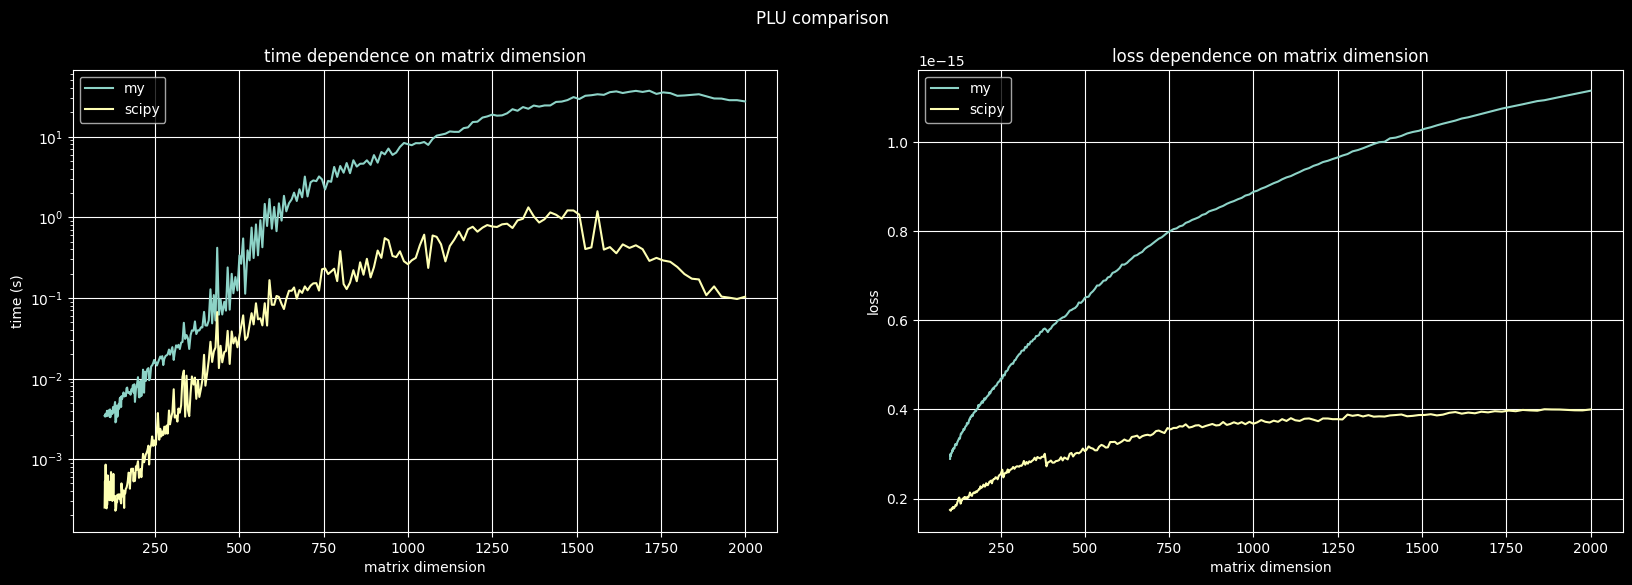

In [5]:
scales = {"time": "log"}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("PLU comparison")

infos = {
    solver: {
        metric: np.array([result[solver][metric] for result in results])
        for metric in results[0][solver].keys()
    }
    for solver in results[0].keys()
}

for solver_name, solver_info in infos.items():
    for j, (metric_name, metric) in enumerate(solver_info.items()):
        axs[j].set_title(f"{metric_name} dependence on matrix dimension")
        axs[j].plot(dimensions, metric, label=solver_name)
        axs[j].legend()

        if metric_name in measures:
            axs[j].set_ylabel(f"{metric_name} ({measures[metric_name]})")
        else:
            axs[j].set_ylabel(metric_name)

        if metric_name in scales:
            axs[j].set_yscale(scales[metric_name])
        axs[j].set_xlabel("matrix dimension")
plt.show()

- Мой метод работает на порядок дольше, что скорее всего связано с тем, что я использую питоновский цикл внутри своей реализации
- Потери ($\|A - PLU\|_F$) примерно в 3 раза больше


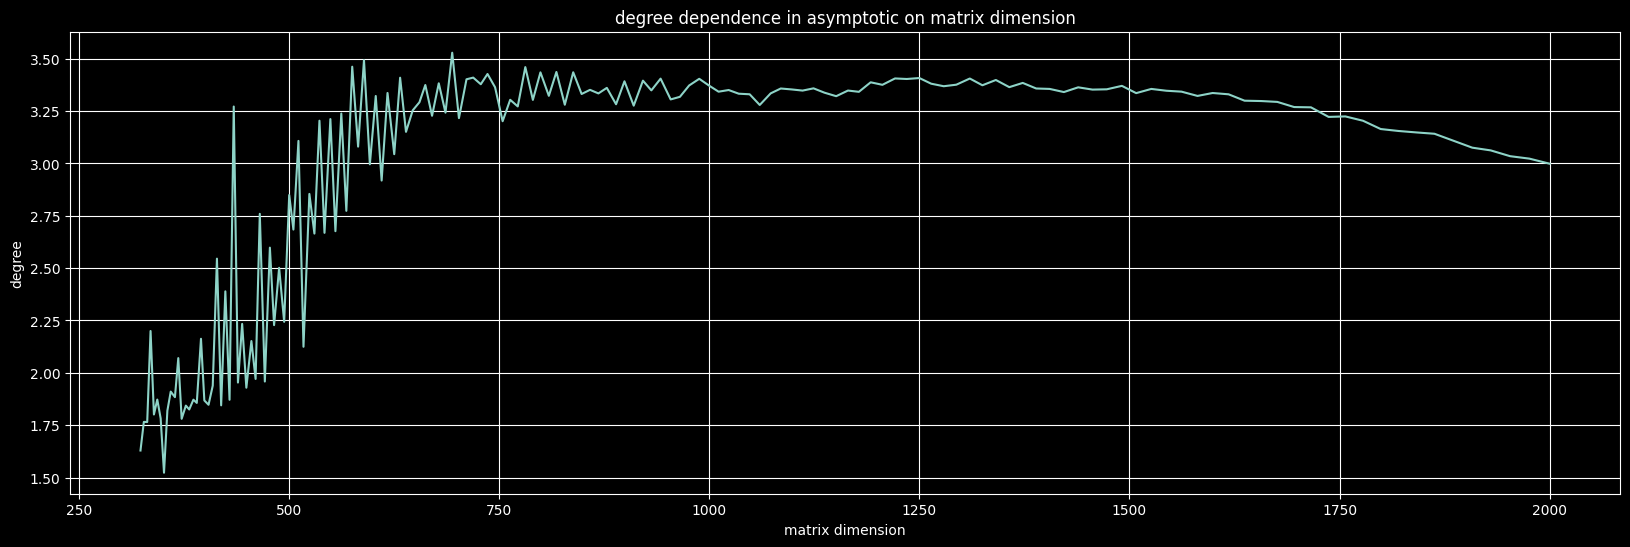

In [6]:
from_ = 100
dimension_ratios = [dimension / dimensions[0] for dimension in dimensions[from_:]]
time_ratios = infos["my"]["time"][from_:] / infos["my"]["time"][0]

plt.figure(figsize=(20, 6))
plt.title("degree dependence in asymptotic on matrix dimension")
plt.plot(dimensions[from_:], np.log(time_ratios) / np.log(dimension_ratios))
plt.ylabel("degree")
plt.xlabel("matrix dimension")
plt.show()

Как можно заметить степень в сложности стремится к 3 на больших размерностях, что подтверждает нашу оценку $O(n^3)$


## Задача 2 (35 pts)

## Ускорение Андерсена

Многие итерационные методы в вычислительной линейной алгебре могут быть записаны в форме итерации неподвижной точки

$$ x\_{k+1} = f(x_k), $$

так что решение задачи удовлетворяет условию $x^* = f(x^*)$. Достаточным условием сходимости такого итерационного процесса для функции $f$ является её Липшецевость с константой $L < 1$ и непрерывная дифференцируемость в окрестности $x^*$ так что $|f'(x^*)| < L$.
Вокруг итераций такого типа существует довольно много разнообразной теории, но нас будет интересовать специальный способ ускорения сходимости такого итерационного процесса под названием **ускорение Андерсена**.
Основная идея метода в представлении следующего приближения как линейной комбинации нескольких предыдущих значений функции $f$, более формально

$$ x*{k+1} = \sum*{i=0}^{m-1} \alpha*i f(x*{k-m+i}), $$

где $m$ - это размер истории, который необходимо хранить и который задаётся до запуска метода, и $\alpha \in \mathbb{R}^n$ ищется как решение следующей задачи оптимизации

$$ \min*{\alpha} \| R\alpha\|\_2, \quad \text{subject to} \quad \sum*{i=0}^{m-1} \alpha_i = 1, $$

где $R = [r_0, \ldots, r_{m-1}]$ и $r_i = f(x_i) - x_i$ вектора невязок.
Отметим, что при $m=1$ мы получим исходную итерацию неподвижной точки.

Заметим, что задача поиска коэффициентов $\alpha_i$ очень похожа на стандартную задачу наименьших квадратов, которую можно решить с помощью функции `np.linalg.lstsq`, но присутствует дополнительное нормировочное ограничение на коэффициенты.

- Придумайте, как равносильно преобразовать задачу к виду, который позволит получить решение с помощью функции `np.linalg.lstsq`.
- Сравните получаемый ответ на случайных данных (матрица $R$) с решением исходной задачи, полученным с помощью функции `scipy.optimize.minimize`.


Рассмотрим задачу:\
\
$
\begin{cases}
  R\alpha = 0 \\
  \sum \limits_{i = 0}^{m-1} \alpha_i = 1
\end{cases}
\Leftrightarrow
\begin{cases}
  R\alpha = 0 \\
  C\sum \limits_{i = 0}^{m-1} \alpha_i = C
\end{cases}
\Leftrightarrow
\begin{bmatrix}
  & R & \\ 
C & \ldots & C
\end{bmatrix} \alpha =
\begin{bmatrix}
0 \\
\ldots \\
0 \\
C
\end{bmatrix}
\forall C
$\
\
Тогда если мы будем искать решение этой задачи с помощью метода наименьших квадратов, то получим приближенное решение исходной задачи


In [4]:
def minimize_norm_lstsq(R):
    C = 1e9
    b = np.zeros(R.shape[0] + 1)
    b[-1] = C

    R_ = np.vstack((R, C * np.ones(R.shape[1])))
    alpha, *_ = np.linalg.lstsq(R_, b, rcond=None)
    return alpha

Попробуем решение этим методом на рандомных матрицах


In [7]:
N = 200


def test_lstsq():
    result = {}

    func = lambda alpha: np.linalg.norm(R @ alpha)

    R = np.random.randn(N, N)

    alpha = minimize_norm_lstsq(R)
    result["my"] = {
        "norm": func(alpha),
        "alpha_sum": np.sum(alpha),
    }

    alpha = minimize(
        func,
        np.ones(N) / N,
        constraints=[{"type": "eq", "fun": lambda alpha: np.sum(alpha) - 1}],
    ).x
    result["scipy"] = {
        "norm": func(alpha),
        "alpha_sum": np.sum(alpha),
    }

    return result


results = Parallel(32, verbose=10)(delayed(test_lstsq)() for _ in range(100))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=32)]: Done  48 out of 100 | elapsed:    1.7s remaining:    1.8s
[Parallel(n_jobs=32)]: Done  59 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=32)]: Done  70 out of 100 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=32)]: Done  81 out of 100 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=32)]: Done  92 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    2.9s finished


In [8]:
infos = {
    solver: {
        metric: np.array([result[solver][metric] for result in results])
        for metric in results[0][solver].keys()
    }
    for solver in results[0].keys()
}

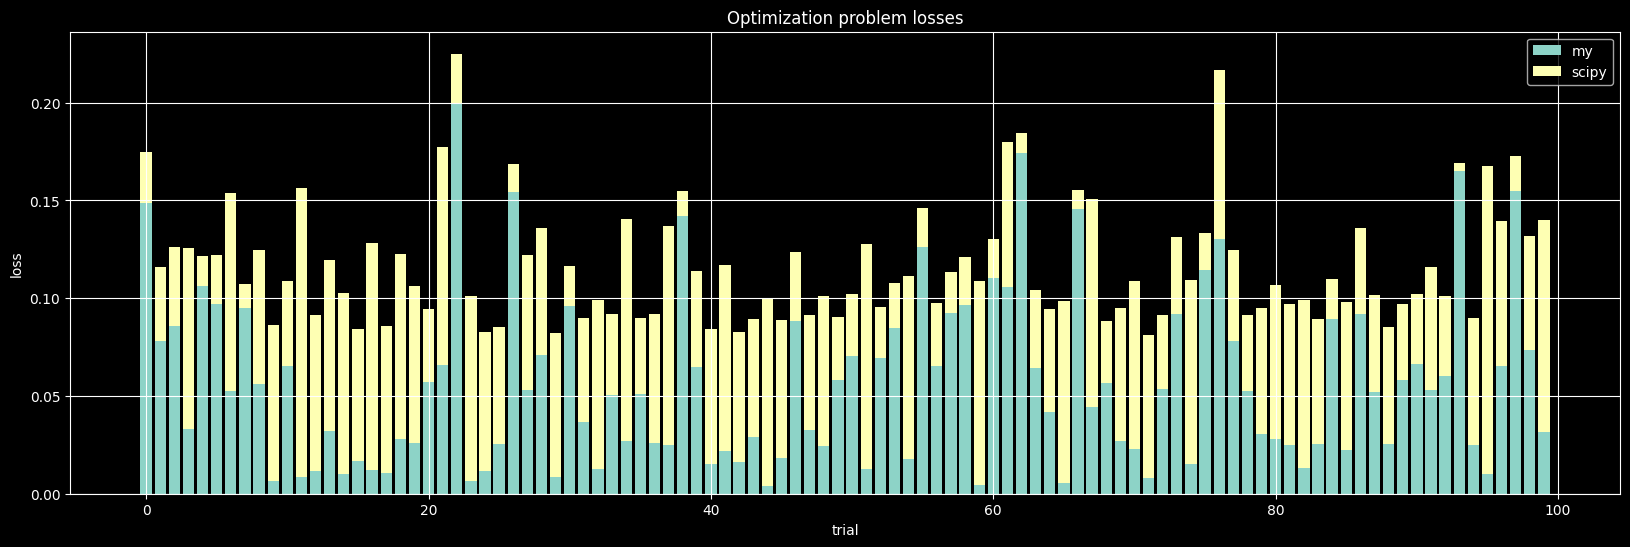

In [9]:
plt.figure(figsize=(20, 6))
plt.title("Optimization problem losses")
for i, (solver, solver_info) in enumerate(infos.items()):
    plt.bar(
        np.arange(len(solver_info["norm"])),
        solver_info["norm"],
        label=solver,
        zorder=1 - i,
    )
plt.legend()
plt.ylabel("loss")
plt.xlabel("trial")
plt.show()

Убедимся, что оба метода удовлетворяют условиям


In [10]:
infos["my"]["alpha_sum"], infos["scipy"]["alpha_sum"]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

Как видно мой метод зачастую дает лучшее решение, чем `scipy.optimize.minimize`


### Степенной метод (10 pts)

- Запишите степенной метод в виде итерации неподвижной точки. Чему равна функция $f$?
- Реализуйте ускорение Андерсена для степенного метода с использованием подхода к решению вспомогательной задачи на коэффициенты $\alpha$, полученным выше. Cравните сходимости обычного и ускоренного степенного метода по времени и числу итераций? Рассмотрите различные значения для размера истории и проанализируйте влияние этого гиперпараметра на скорость сходимости (по времени и по числу итераций)


Запишем степеной метод: $x^{(k + 1)} = \frac{Ax^{(k)}}{\|Ax^{(k)}\|}$\
Это можно переписать в виде: $x^{(k + 1)} = f(x^{(k)}), f(x) = \frac{Ax}{\|Ax\|}$


In [15]:
def power_method(A, x):
    v = A @ x
    return v / np.linalg.norm(v, axis=0)


def anderson_acceleration(func, x_0, history_size=5, max_iters=10000, tol=1e-12):
    x = x_0.copy().flatten()[:, np.newaxis]
    f_xs = func(x)
    R = f_xs - x
    for it in range(max_iters):
        if np.linalg.norm(R) < tol:
            return x, it + 1
        alpha = minimize_norm_lstsq(R)[:, np.newaxis]
        x = f_xs @ alpha
        f_x = func(x)
        if R.shape[1] < history_size:
            f_xs = np.hstack((f_xs, f_x))
            R = np.hstack((R, f_x - x))
            continue
        f_xs = np.hstack((f_xs[:, 1:], f_x))
        R = np.hstack((R[:, 1:], f_x - x))
    return x, max_iters

Запустим метод Андресона на симметричных матрицах с параметрами истории от 1 до 100 с функцией потерь: $\|Ax - \lambda x\|_2$, где $\lambda$ - максимальное по модулю собственное значение найденное с помощью `np.linalg.eigvals`


In [18]:
np.random.seed(777)

MATRIX_COUNT = 3
N = 1000
datas = []
for i in range(MATRIX_COUNT):
    A = np.random.randn(N, N)
    A = (A + A.T) / 2
    eig_val = max(np.linalg.eigvals(A), key=abs).real
    datas.append((A, eig_val))


def test_anderson_acceleration(datas, history_size):
    results = []
    for data in datas:
        A, eig_val = data
        start = time.time()
        x, it = anderson_acceleration(
            partial(power_method, A), np.ones(A.shape[1]), history_size
        )
        results.append(
            {
                "iteration count": it,
                "time": time.time() - start,
                "loss": np.linalg.norm(A @ x - eig_val * x),
            }
        )
    return results


history_sizes = np.arange(16) + 1
results = Parallel(32, verbose=10)(
    delayed(test_anderson_acceleration)(datas, history_size)
    for history_size in history_sizes
)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   3 out of  16 | elapsed:    2.3s remaining:    9.8s
[Parallel(n_jobs=32)]: Done   5 out of  16 | elapsed:    3.3s remaining:    7.3s
[Parallel(n_jobs=32)]: Done   7 out of  16 | elapsed:    4.3s remaining:    5.5s
[Parallel(n_jobs=32)]: Done   9 out of  16 | elapsed:    4.5s remaining:    3.5s
[Parallel(n_jobs=32)]: Done  11 out of  16 | elapsed:    5.4s remaining:    2.5s
[Parallel(n_jobs=32)]: Done  13 out of  16 | elapsed:    5.8s remaining:    1.3s
[Parallel(n_jobs=32)]: Done  16 out of  16 | elapsed:    6.6s finished


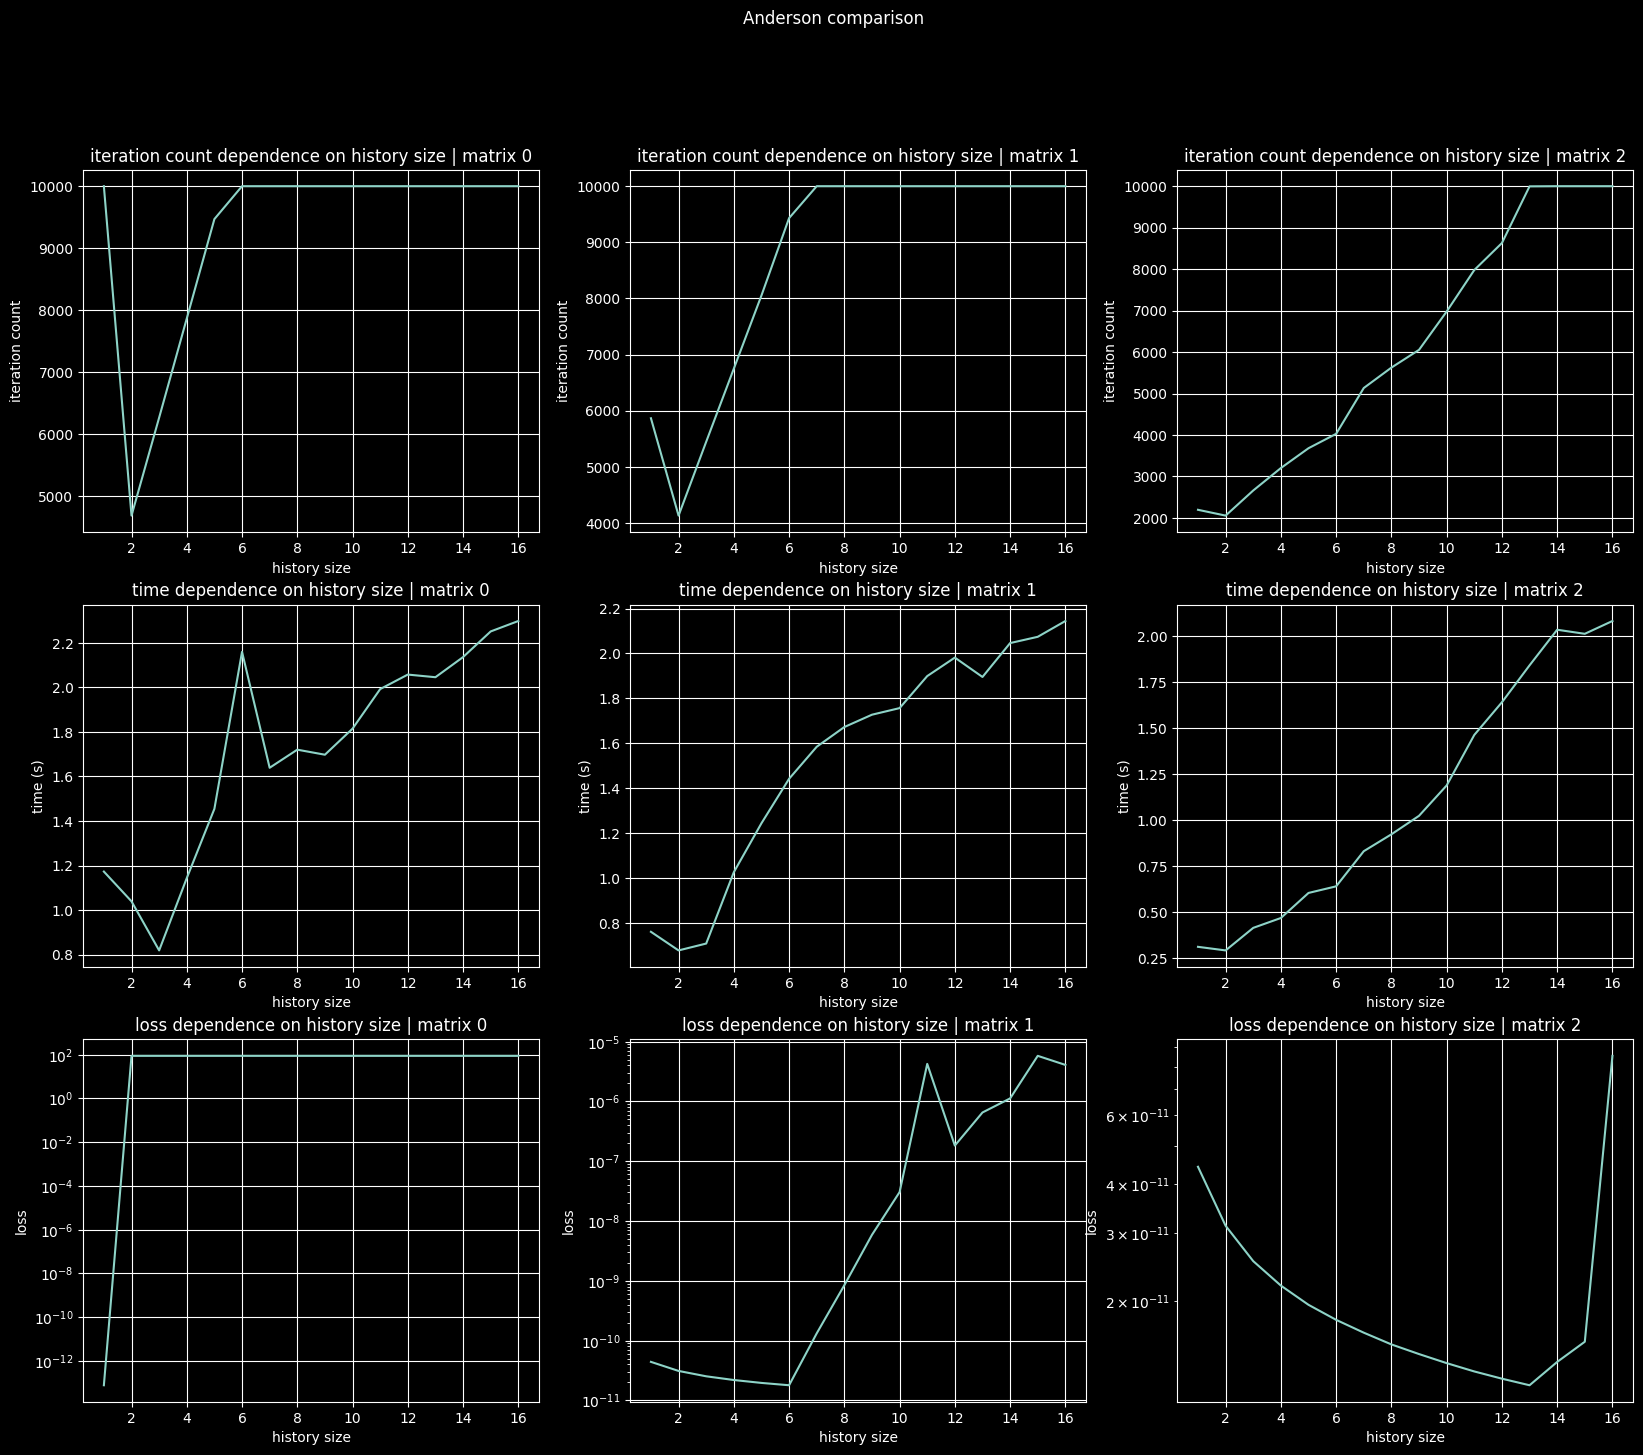

In [22]:
scales = {"loss": "log"}

infos = {
    metric: np.array(
        [[matrix_result[metric] for matrix_result in result] for result in results]
    ).T
    for metric in results[0][0].keys()
}

fig, axs = plt.subplots(len(infos), MATRIX_COUNT, figsize=(20, 16))
fig.suptitle("Anderson comparison")

for i, (metric_name, metric_list) in enumerate(infos.items()):
    for j, metric in enumerate(metric_list):
        axs[i, j].set_title(f"{metric_name} dependence on history size | matrix {j}")
        if metric_name in measures:
            axs[i, j].set_ylabel(f"{metric_name} ({measures[metric_name]})")
        else:
            axs[i, j].set_ylabel(metric_name)

        if metric_name in scales:
            axs[i, j].set_yscale(scales[metric_name])
        axs[i, j].set_xlabel("history size")
        axs[i, j].plot(history_sizes, metric)

plt.show()

In [24]:
for metric, metric_list in infos.items():
    print(f"Default power method {metric}: {metric_list[:, 0]}")

Default power method iteration count: [10000  5864  2196]
Default power method time: [1.1727984  0.76218581 0.31197619]
Default power method loss: [7.54150459e-14 4.40949965e-11 4.42751046e-11]


Как можно заметить для этой задачи:

- Обычный метод хоть иногда и не сходится, но выдаёт адекватный результат всегда
- Ускорение Андерсона иногда неплохо работает:
  - Там где не сходился обычный метод, он сходится, но не туда
  - Он сходится быстрее при небольшом размере истории


### Неотрицательное матричное разложение (20 pts)

Задача неотрицательного матричного разложения заключается в поиске разложения данной матрицы на факторы с неотрицательными компонентами, то есть решение следующей задачи оптимизации

$$ \min\_{W \geq 0, H \geq 0} \|X - WH\|\_F^2, $$

где $X \in \mathbb{R}^{m \times n}$, $W \in \mathbb{R}^{m \times k}$ и $H \in \mathbb{R}^{k \times n}$, так что $k < n$. Известно что такая задача является NP-полной, но существуют различные подходы к её приближённому решению. Одним из таких подходов является идея **попеременной оптимизации**, в которой по очереди фиксируются матрицы $W^{(k)}$ и $H^{(k)}$ и обновляются матрицы $H$ и $W$ соответственно. Так как при фиксированной одной матрице задача становится очень похожа на задачу линейных наименьших квадратов, но с дополнительным ограничением неотрицательности на искомую матрицу.

- Реализуйте наивный алгориитм приближённого решения задачи неотрицательного матричного разложения на основе попеременной оптимизации. Для получения решения всмомогательных задач можно проецировать результат решения линейной задачи наименьших квадратов на множество матриц с неотрицательными элементами. Это делается простым занулением отрицательных элементов, что надеюсь очевидно для вас. Существуют [другие подходы](https://arxiv.org/pdf/1401.5226.pdf) к получению промежуточных значений для матриц $W^{(k)}$ и $H^{(k)}$, которые вы можете протестировать, если выше описанная стратегия не будет сходиться.

- Одну итерацию обновления матриц $(W, H)$ можно представить как итерацию неподвижной точки вида

$$(W^{(k+1)}, H^{(k+1)}) = F(W^{(k)}, H^{(k)}), $$

где внутри $F$ спрятаны решения вспомогательных задач оптимизации. А значит реализованный вами выше метод можно ускорить с помощью ускорения Андерсена. Реализуйте ускоренный таким образом метод приближённого решения задачи неотрицательного матричного разложения.

- Рассмотрите задачу тематического моделирования, то есть разбиения документов по темам на основе слов, которые в документах используются. Эту задачу можно формализовать с помощью неотрицательного матричного разложения матрицы "слов-документов", элемент $(i, j)$ которой равен 1 если $i$-ое слово используется в $j$-ом документе. Это самый простой способ представления текстовых документов в виде пригодном для их анализа методами вычислительной линейной алгебры. Можно протестировать чуть более продвинутый способ представления слов и документов под названием tf-idf, подробности [тут](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Для построения матрицы $X$ используйте тестовый датасет [20newsgroup](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups). В контексте этого приложения параметр $k$ - это число тем, матрица $W$ содержит распределение слов по темам, а матрица $H$ коэффициенты разложения каждого документа по темам. Так как все элементы матриц неотрицательны, мы можем интерпретировать их как веса и доли, что упрощает интерпретацию результатов в рамках выбранной предметной области. Сравните на этих данных сходимость базовой и ускоренной реализации метода приближённого решения задачи неотрицательного матричного разложения (по времени и по итерациям). Прокомментируйте полученные результаты.


In [79]:
def nonnegative_matrix_decomposition(X, W_0, H_0, max_iter=100, tol=1e-6):
    W, H = W_0.copy(), H_0.copy()

    for it in tqdm(range(max_iter)):
        H = np.maximum(0, np.linalg.lstsq(W, X, rcond=None)[0])
        W = np.maximum(0, np.linalg.lstsq(H.T, X.T, rcond=None)[0].T)

        if np.linalg.norm(X - W @ H) < tol:
            return (W, H), it + 1

    return (W, H), max_iter

In [80]:
dataset = fetch_20newsgroups(subset="all")
X = TfidfVectorizer(min_df=0.1, max_df=0.9).fit_transform(dataset["data"]).toarray()
X.shape

(18846, 180)

In [81]:
M, N = X.shape
K = len(np.unique(dataset["target"]))

(W, H), it = nonnegative_matrix_decomposition(
    X, np.random.rand(M, K), np.random.rand(K, N)
)

100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


In [83]:
np.linalg.norm(W @ H - X)

94.2810920648618

Наивный алгоритм работает довольно плохо
